In [2]:
!pip install Crypto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 kB 14.9 MB/s eta 0:00:00


In [3]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.2 MB/s eta 0:00:00


In [4]:
from PIL import Image
from Crypto.Cipher import AES
import base64
import hashlib
from Crypto.Random import get_random_bytes
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

Enter the original image path: /content/original_image.jpg
Enter the message to be hide: Welcome to Image steganography Based on Edge Detection-Driven LSB Technique Project.
Enter the encryption key: stego

Embedding encrypted message...

Encrypted message: J20v6WnL2JWv9leNEc5DsT+yNrEwEFdhyxQseiBTLfb2flClwlxtX5VjuMlCTnPG3koq61Rc6HEZkHSn4ZvIVOrtUpeflKeD0JUS8DyPDvCv04iicFG0D6OY6TdURRWvP8q0i2t84jdhGJYz48KbFw==

Message embedded and saved as 'stego_image_aes.png'

Enter the same key to decrypt the message...
Enter the decryption key: stego

Decrypted message: Welcome to Image steganography Based on Edge Detection-Driven LSB Technique Project.


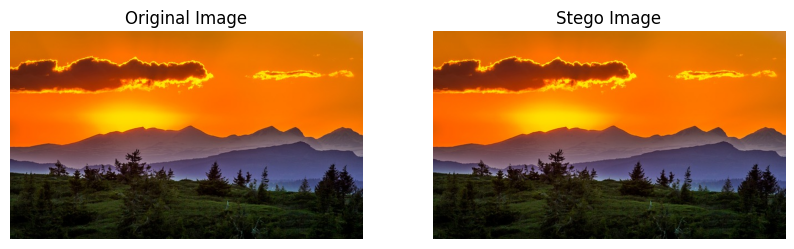

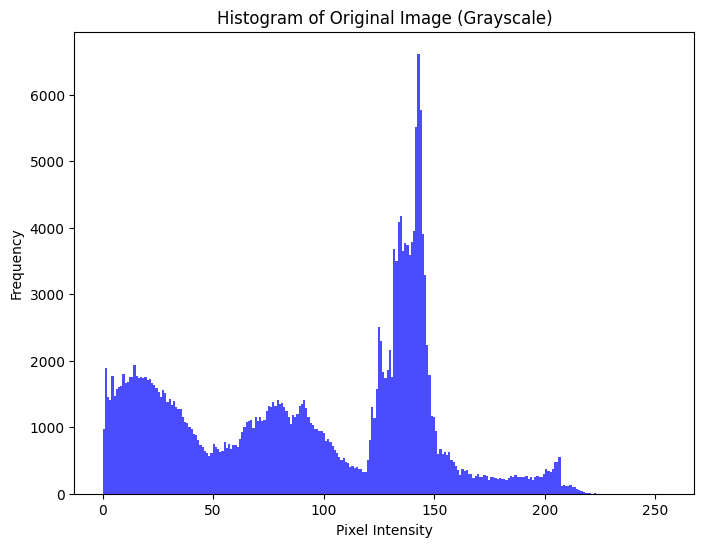

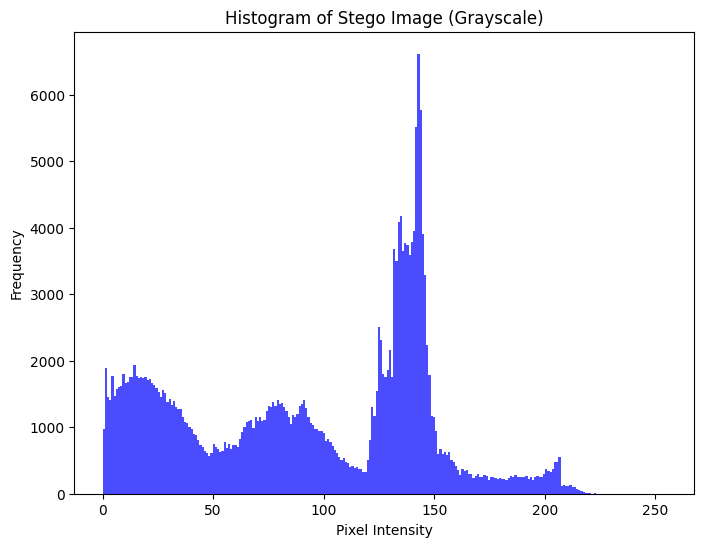

In [ ]:
DEFAULT_THRESHOLD = 128
NUM_BITS = 8

class EdgeDetectStego:
    def __init__(self, threshold=DEFAULT_THRESHOLD, edge_bits=4, non_edge_bits=1, block_width=3, block_height=3):
        self.threshold = threshold
        self.edge_bits = edge_bits
        self.non_edge_bits = non_edge_bits
        self.block_width = block_width
        self.block_height = block_height

    def pad_message(self, message):
        padding_length = AES.block_size - (len(message) % AES.block_size)
        return message + chr(padding_length) * padding_length

    def unpad_message(self, message):
        padding_length = ord(message[-1])
        return message[:-padding_length]

    def derive_key(self, user_key):
        return hashlib.sha256(user_key.encode()).digest()

    def encrypt_message(self, message, user_key):

        key = self.derive_key(user_key)
        #iv = b'0123456789abcdef'
        iv = get_random_bytes(AES.block_size)
        cipher = AES.new(key, AES.MODE_CBC, iv)
        encrypted = cipher.encrypt(self.pad_message(message).encode('utf-8'))

        encrypted_message = iv + encrypted
        return base64.b64encode(encrypted_message).decode('utf-8')

    def decrypt_message(self, encrypted_message, user_key):

        try:
            key = self.derive_key(user_key)
            encrypted_message = base64.b64decode(encrypted_message)

            iv = encrypted_message[:AES.block_size]
            encrypted = encrypted_message[AES.block_size:]

            cipher = AES.new(key, AES.MODE_CBC, iv)
            decrypted = cipher.decrypt(encrypted).decode('utf-8')

            return self.unpad_message(decrypted)
        except (ValueError, KeyError, UnicodeDecodeError):
            return "Wrong key entered"

    def embed_message(self, image_path, message, user_key):


        encrypted_message = self.encrypt_message(message, user_key)
        print("\nEncrypted message:", encrypted_message)

        message_bits = ''.join(f'{ord(c):08b}' for c in encrypted_message)

        img = Image.open(image_path).convert("RGB")
        pixels = np.array(img)

        width, height = img.size
        bit_index = 0

        for y in range(0, height, self.block_height):
            for x in range(0, width, self.block_width):
                num_bits = self.edge_bits if self.is_edge_block(pixels, x, y) else self.non_edge_bits

                for dy in range(self.block_height):
                    for dx in range(self.block_width):
                        if (x + dx < width) and (y + dy < height):
                            if bit_index < len(message_bits) and num_bits > 0:
                                for channel in range(3):
                                    if bit_index < len(message_bits):
                                        self.embed_bits(pixels, x + dx, y + dy, message_bits[bit_index:bit_index + num_bits], channel)
                                        bit_index += num_bits

        encrypted_image = Image.fromarray(pixels)
        return encrypted_image, encrypted_message

    def extract_message(self, image_path, user_key, encrypted_message_length):

        img = Image.open(image_path).convert("RGB")
        pixels = np.array(img)

        width, height = img.size
        message_bits = ""
        bit_index = 0
        total_bits = encrypted_message_length * 8

        for y in range(0, height, self.block_height):
            for x in range(0, width, self.block_width):
                num_bits = self.edge_bits if self.is_edge_block(pixels, x, y) else self.non_edge_bits

                for dy in range(self.block_height):
                    for dx in range(self.block_width):
                        if (x + dx < width) and (y + dy < height):
                            if bit_index < total_bits:
                                for channel in range(3):
                                    if bit_index < total_bits:
                                        bits = self.extract_bits(pixels, x + dx, y + dy, num_bits, channel)
                                        message_bits += bits
                                        bit_index += num_bits

        encrypted_message = ''.join(chr(int(message_bits[i:i+8], 2)) for i in range(0, total_bits, 8))

        decrypted_message = self.decrypt_message(encrypted_message, user_key)
        return decrypted_message

    def is_edge_block(self, pixels, x, y):

        if x + self.block_width + 1 > pixels.shape[1] or y + self.block_height + 1 > pixels.shape[0]:
            return False

        gx = pixels[y:y + self.block_height, x + 1:x + self.block_width + 1, 0] - pixels[y:y + self.block_height, x:x + self.block_width, 0]
        gy = pixels[y + 1:y + self.block_height + 1, x:x + self.block_width, 0] - pixels[y:y + self.block_height, x:x + self.block_width, 0]
        gradient_magnitude = np.sqrt(gx**2 + gy**2)

        return np.any(gradient_magnitude > self.threshold)

    def embed_bits(self, pixels, x, y, bits, channel):
        current_value = pixels[y, x, channel].astype(np.int32)
        bits_value = int(bits, 2)
        mask = (1 << len(bits)) - 1
        new_value = (current_value & ~mask) | bits_value
        pixels[y, x, channel] = np.clip(new_value, 0, 255)

    def extract_bits(self, pixels, x, y, num_bits, channel):
        value = pixels[y, x, channel] & ((1 << num_bits) - 1)
        return f"{value:0{num_bits}b}"


def plot_histograms(image_path, encrypted_image_path, save_plot_path1,save_plot_path2):
     original_image = Image.open(image_path).convert("L")
     encrypted_image = Image.open(encrypted_image_path).convert("L")

     original_pixels = np.array(original_image).flatten()
     encrypted_pixels = np.array(encrypted_image).flatten()


     plt.figure(figsize=(8, 6))
     plt.hist(original_pixels, bins=256, range=(0, 255), color='blue', alpha=0.7)
     plt.title("Histogram of Original Image (Grayscale)")
     plt.xlabel("Pixel Intensity")
     plt.ylabel("Frequency")
     plt.savefig(save_plot_path1)
     plt.show()

    # encrypted image histogram
     plt.figure(figsize=(8, 6))
     plt.hist(encrypted_pixels, bins=256, range=(0, 255), color='blue', alpha=0.7)
     plt.title("Histogram of Stego Image (Grayscale)")
     plt.xlabel("Pixel Intensity")
     plt.ylabel("Frequency")
     plt.savefig(save_plot_path2)
     plt.show()

def main():
    image_path = input("Enter the original image path: ")
    message = input("Enter the message to be hide: ")
    user_key = input("Enter the encryption key: ")

    stego = EdgeDetectStego()

    print("\nEmbedding encrypted message...")
    encrypted_image, encrypted_message = stego.embed_message(image_path, message, user_key)

    encrypted_image_path = 'stego_image_aes.png'
    encrypted_image.save(encrypted_image_path)
    print(f"\nMessage embedded and saved as '{encrypted_image_path}'")

    print("\nEnter the same key to decrypt the message...")
    decrypt_key = input("Enter the decryption key: ")

    extracted_message = stego.extract_message(encrypted_image_path, decrypt_key, len(encrypted_message))

    if extracted_message == "Wrong key entered":
        print("\nWrong key entered")
    else:
        print("\nDecrypted message:", extracted_message)

    original_image = Image.open(image_path)
    encrypted_image = Image.open(encrypted_image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Stego Image")
    plt.imshow(encrypted_image)
    plt.axis("off")
    plt.show()
    save_plot_path1 = 'histograms.png'
    save_plot_path2 = 'histograms_stego.png'
    plot_histograms(image_path, encrypted_image_path, save_plot_path1,save_plot_path2)



if __name__ == "__main__":
    main()


# **Chi-square Test**

Chi-square statistic: 33.57


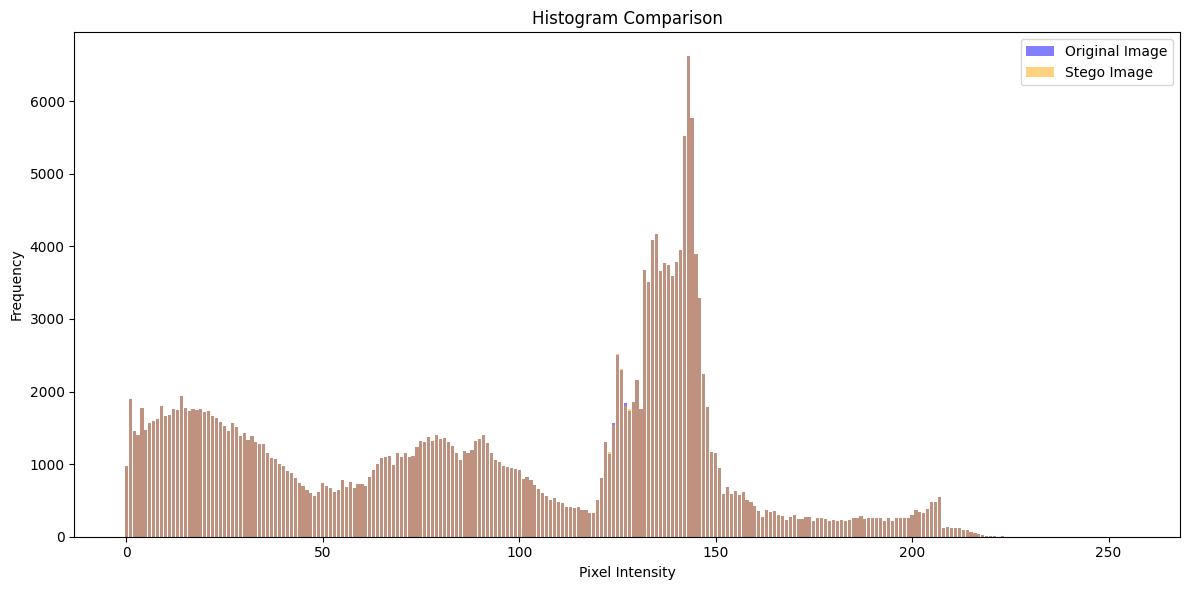

In [ ]:
def compute_chi_square(original_image, stego_image):
    original_array = np.array(original_image.convert("L"))
    stego_array = np.array(stego_image.convert("L"))

    original_hist, _ = np.histogram(original_array.flatten(), bins=256, range=(0, 256))
    stego_hist, _ = np.histogram(stego_array.flatten(), bins=256, range=(0, 256))
    expected_freq = (original_hist + stego_hist) / 2

    expected_freq = np.where(expected_freq == 0, 1, expected_freq)

    chi_square = np.sum(((original_hist - expected_freq) ** 2) / expected_freq)
    return chi_square, original_hist, stego_hist

def plot_histograms_new(original_hist, stego_hist):
    plt.figure(figsize=(12, 6))
    plt.bar(range(256), original_hist, alpha=0.5, label="Original Image", color='blue')
    plt.bar(range(256), stego_hist, alpha=0.5, label="Stego Image", color='orange')
    plt.title("Histogram Comparison")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.savefig("/content/chi_square_histograms_for_text.png", dpi=300)
    plt.show()

original_image_path = "/content/original_image.jpg"
stego_image_path = "/content/stego_image_aes.png"

original_image = Image.open(original_image_path)
stego_image = Image.open(stego_image_path)
chi_square, original_hist, stego_hist = compute_chi_square(original_image, stego_image)

print(f"Chi-square statistic: {chi_square:.2f}")

plot_histograms_new(original_hist, stego_hist)

# **Mean Squared Error (MSE)**

In [ ]:
image1 = cv2.imread('/content/original_image.jpg')
image2 = cv2.imread('/content/stego_image_aes.png')

if image1.shape != image2.shape:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

channels1 = cv2.split(image1)
channels2 = cv2.split(image2)

mse_per_channel = []
for ch1, ch2 in zip(channels1, channels2):
    mse_channel = mean_squared_error(ch1, ch2)
    mse_per_channel.append(mse_channel)

mse_color = np.mean(mse_per_channel)

print(f"Mean Squared Error (Color Images): {mse_color}")

Mean Squared Error (Color Images): 0.0008482537577365164


# **Peak Signal-to-Noise Ratio (PSNR)**

In [ ]:
def calculate_psnr(image1, image2):
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    image1 = image1.astype("float32")
    image2 = image2.astype("float32")

    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')

    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

image1 = cv2.imread('/content/original_image.jpg')
image2 = cv2.imread('/content/stego_image_aes.png')

psnr_value = calculate_psnr(image1, image2)
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr_value} dB")

Peak Signal-to-Noise Ratio (PSNR): 78.84554290771484 dB


# **Structural Similarity Index (SSIM)**

In [ ]:
def calculate_ssim_color(image1, image2):
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    channels1 = cv2.split(image1)
    channels2 = cv2.split(image2)

    ssim_values = []
    for ch1, ch2 in zip(channels1, channels2):
        ssim_value, _ = ssim(ch1, ch2, full=True)
        ssim_values.append(ssim_value)

    overall_ssim = np.mean(ssim_values)
    return overall_ssim

image1 = cv2.imread('/content/original_image.jpg')
image2 = cv2.imread('/content/stego_image_aes.png')

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

ssim_value = calculate_ssim_color(image1, image2)
print(f"Structural Similarity Index (SSIM): {ssim_value}")

Structural Similarity Index (SSIM): 0.9999952315729281
